In [1]:
%matplotlib notebook

In [2]:

# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import importlib as im
from matplotlib import cm
import copy
import pandas as pd
from scipy import integrate
from scipy import signal
from IPython.core.display import display, HTML


A simple reaction A-->B


<IPython.core.display.Javascript object>


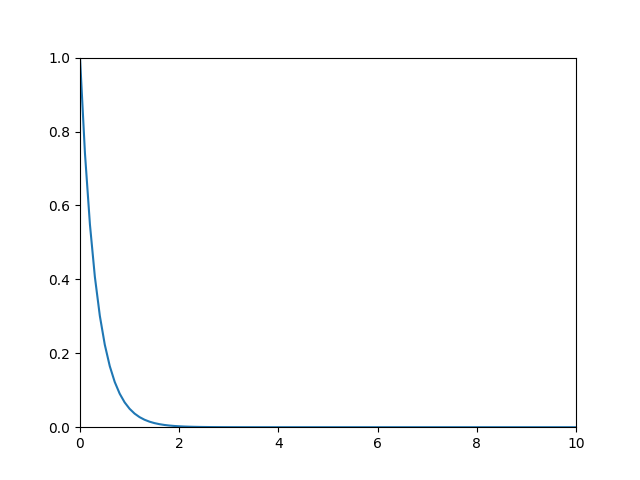

In [3]:
def f(y, t, k1):
    Dy = -1*k1*y
    return(Dy)
    
t = np.linspace(0, 10, 101)
y0=[1.0]
k1=3
constants=(k1,)
soln = odeint(f, y0, t, args=constants)


fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(t,soln[:,0])
ax1.set_ylim(0,1)
ax1.set_xlim(0,t[-1])
plt.show()




A reversible reaction:
    
    A<-- --> B
    

<IPython.core.display.Javascript object>


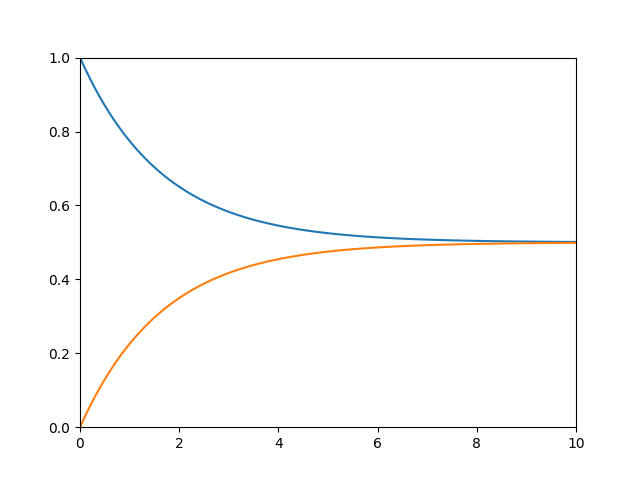

In [4]:
def f(y, t, k1, k2):
    DA = -1*k1*y[0] + k2*y[1]
    DB = -1* DA #k1*y[0] - k2*y[1]
    
    return([DA, DB])
    
t = np.linspace(0, 10, 101)

y0=[1.0, 0.0]
k1=0.3
k2=0.3

constants=(k1,k2)
soln = odeint(f, y0, t, args=constants)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(t,soln[:,0])
ax1.plot(t,soln[:,1])

ax1.set_ylim(0,1)
ax1.set_xlim(0,t[-1])
plt.show()


In [5]:
[soln[-1,0], soln[-1,1]]

[0.50123937413206665, 0.49876062586793302]

Using the results from the previous simulation as the starting point for the next:

<IPython.core.display.Javascript object>


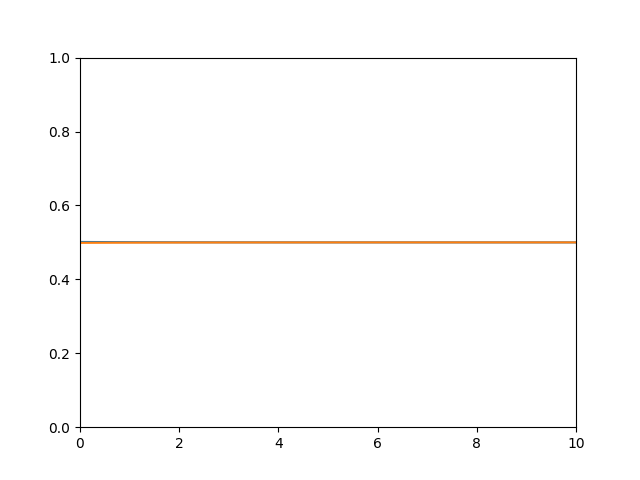

In [6]:
t = np.linspace(0, 10, 101)

y0=[soln[-1,0], soln[-1,1]]
k1=0.3
k2=0.3

constants=(k1,k2)
soln2 = odeint(f, y0, t, args=constants)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(t,soln2[:,0])
ax1.plot(t,soln2[:,1])

ax1.set_ylim(0,1)
ax1.set_xlim(0,t[-1])
plt.show()


Now, a DIRK relaxation experiment

<IPython.core.display.Javascript object>


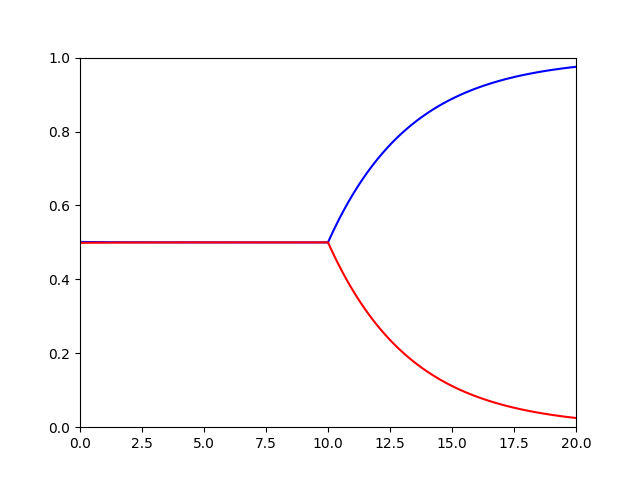

In [7]:
t3 = np.linspace(0, 10, 101)

y0=[soln2[-1,0], soln2[-1,1]]

k1=0.0
k2=0.3

constants=(k1,k2)
soln3 = odeint(f, y0, t, args=constants)

fig=plt.figure()

ax1=fig.add_subplot(111)
ax1.plot(t,soln2[:,0], color="blue")
ax1.plot(t,soln2[:,1], color="red")

ax1.plot(t3+t[-1],soln3[:,0], color="blue")
ax1.plot(t3+t[-1],soln3[:,1], color="red")

ax1.set_ylim(0,1)
ax1.set_xlim(0,t[-1] + t3[-1])
plt.show()

P -light-> P* --recombination--> P

<IPython.core.display.Javascript object>


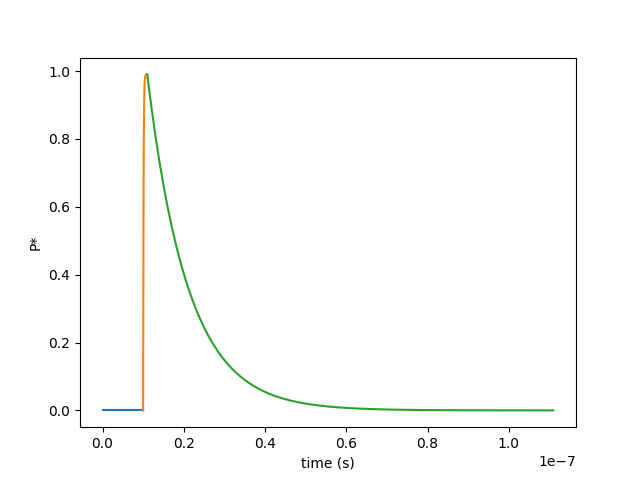

In [8]:
#just a chlorophyll molecule

def f_chl(y, t, PAR, k_recombination):
    DPstar = PAR*y[0] -1*k_recombination*y[1] 
    DPground = k_recombination*y[1] - PAR*y[0]
    return([DPground, DPstar])

# in the dark
dark_values=[1,0] #start with all P in ground state

#in this case we use light intensity as a rate constant 
PAR=0.0  #start in the dark, so PAR=0
k_recombination=1.0e8 #about 10 nanoseconds


constants=(PAR,k_recombination)
dark_t = np.linspace(0, 1e-8, 101) #the time of the dark adaptation
dark_baseline = odeint(f_chl, dark_values, dark_t, args=constants)
dark_end_values=[dark_baseline[-1,0],dark_baseline[-1,1]] 

#now we make a pulse of light
PAR=10000000000.0 
#a nanosecond flash 
flash_t = np.linspace(0, 1e-9, 101) #the time of the dark adaptation
constants=(PAR,k_recombination)
flash = odeint(f_chl, dark_end_values, flash_t, args=constants)

flash_end_values=[flash[-1,0],flash[-1,1]] 

flash_t=flash_t + dark_t[-1]

#now we watch the decay
PAR=0.0

decay_t = np.linspace(0, 1e-7, 101) #the time of the decay curve
constants=(PAR,k_recombination)
decay = odeint(f_chl, flash_end_values, decay_t, args=constants)
decay_end_values=[decay[-1,0],decay[-1,1]] 
decay_t=decay_t+flash_t[-1]


fig=plt.figure()
ax1=fig.add_subplot(111)

ax1.plot(dark_t,dark_baseline[:,1])
ax1.plot(flash_t,flash[:,1])
ax1.plot(decay_t,decay[:,1])

#ax1.set_ylim(0,1)
#ax1.set_xlim(0,t[-1])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('P*')
plt.show()


<IPython.core.display.Javascript object>


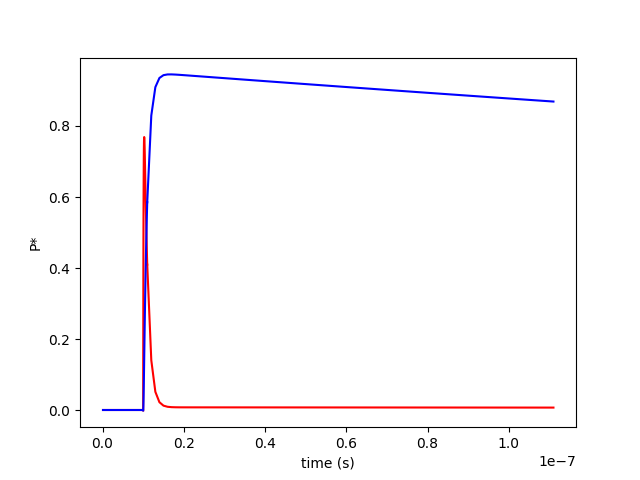

In [9]:
#y[0] is gnd state
#y[1] is Pstar
#y[2] is P+I- Pp_Im

#four rate constants:
# PAR, excitation ground-->Pp
# k_recombination, Pp--> ground state
# kPstar_Pp_Im, electron transfer from P* --> P+I-
# kIm_Pp_Pstar, reverse electron transfer from P+I- --> P*


def f_simple_RC(y, t, PAR, k_recombination, kPstar_Pp_Im, kIm_Pp_Pstar):
    DPstar = PAR*y[0] -1*k_recombination*y[1] - kPstar_Pp_Im*y[1] + kIm_Pp_Pstar*y[2]
    DPground = k_recombination*y[1] - PAR*y[0]
    DPp_Im = kPstar_Pp_Im*y[1] - kIm_Pp_Pstar*y[2]
    return([DPground, DPstar, DPp_Im])

dark_values=[1,0,0] #start with all P in ground state

PAR=0
kPstar_Pp_Im=1e9
kPstar_Im_Pp=1e7

constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp)
dark_t = np.linspace(0, 1e-8, 101) #the time of the dark adaptation
dark_baseline = odeint(f_simple_RC, dark_values, dark_t, args=constants)
dark_end_values=[dark_baseline[-1,0],dark_baseline[-1,1],dark_baseline[-1,2]] 

PAR=10000000000.0 
flash_t = np.linspace(0, 1e-9, 101) #the time of the dark adaptation
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp)
flash = odeint(f_simple_RC, dark_end_values, flash_t, args=constants)
flash_end_values=[flash[-1,0],flash[-1,1],flash[-1,2]] 
flash_t=flash_t + dark_t[-1]

#now we watch the decay
PAR=0.0
decay_t = np.linspace(0, 1e-7, 101) #the time of the decay curve
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp)
decay = odeint(f_simple_RC, flash_end_values, decay_t, args=constants)
decay_end_values=[decay[-1,0],decay[-1,1], decay[-1,2]] 
decay_t=decay_t+flash_t[-1]


fig=plt.figure()
ax1=fig.add_subplot(111)

ax1.plot(dark_t,dark_baseline[:,1], color='red')
ax1.plot(flash_t,flash[:,1], color='red')
ax1.plot(decay_t,decay[:,1], color='red')

ax1.plot(dark_t,dark_baseline[:,2], color='blue')
ax1.plot(flash_t,flash[:,2], color='blue')
ax1.plot(decay_t,decay[:,2], color='blue')

ax1.set_xlabel('time (s)')
ax1.set_ylabel('P*')
plt.show()




<IPython.core.display.Javascript object>


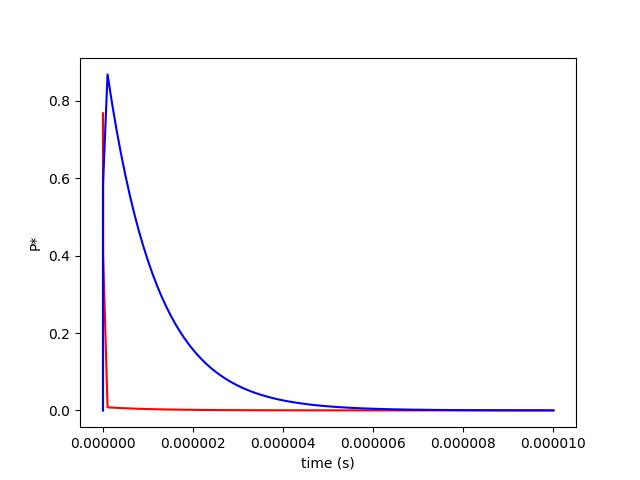

In [10]:
#now we watch the decay
PAR=0.0
decay_t = np.linspace(0, 1e-5, 101) #the time of the decay curve
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp)
decay = odeint(f_simple_RC, flash_end_values, decay_t, args=constants)
decay_end_values=[decay[-1,0],decay[-1,1], decay[-1,2]] 
decay_t=decay_t+flash_t[-1]


fig=plt.figure()
ax1=fig.add_subplot(111)

ax1.plot(dark_t,dark_baseline[:,1], color='red')
ax1.plot(flash_t,flash[:,1], color='red')
ax1.plot(decay_t,decay[:,1], color='red')

ax1.plot(dark_t,dark_baseline[:,2], color='blue')
ax1.plot(flash_t,flash[:,2], color='blue')
ax1.plot(decay_t,decay[:,2], color='blue')

ax1.set_xlabel('time (s)')
ax1.set_ylabel('P*')
plt.show()


<IPython.core.display.Javascript object>


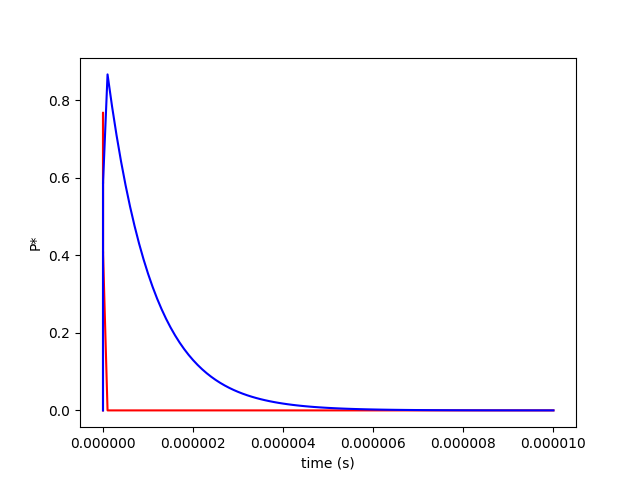

In [11]:
#A 2-stage RC with two decay routes

#y[0] is gnd state
#y[1] is Pstar
#y[2] is P+I- Pp_Im

#four rate constants:
# PAR, excitation ground-->Pp
# k_recombination, Pp--> ground state
# kPstar_Pp_Im, electron transfer from P* --> P+I-
# kPstar_Im_Pp, reverse electron transfer from P+I- --> P*

# kIm_ground, recombination from P+I- --> ground



def f_simple_RC_multiple_decays(y, t, PAR, k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground):
    DPstar = PAR*y[0] -1*k_recombination*y[1] - kPstar_Pp_Im*y[1] 
    DPground = k_recombination*y[1] - PAR*y[0]
    DPp_Im = kPstar_Pp_Im*y[1] - kPstar_Im_Pp*y[2]
    return([DPground, DPstar, DPp_Im])

dark_values=[1,0,0] #start with all P in ground state

PAR=0
kPstar_Pp_Im=1e9
kPstar_Im_Pp=1e6
kIm_ground=1e6

constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground)
dark_t = np.linspace(0, 1e-8, 101) #the time of the dark adaptation
dark_baseline = odeint(f_simple_RC_multiple_decays, dark_values, dark_t, args=constants)
dark_end_values=[dark_baseline[-1,0],dark_baseline[-1,1],dark_baseline[-1,2]] 

PAR=10000000000.0 
flash_t = np.linspace(0, 1e-9, 101) #the time of the dark adaptation
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground)
flash = odeint(f_simple_RC_multiple_decays, dark_end_values, flash_t, args=constants)
flash_end_values=[flash[-1,0],flash[-1,1],flash[-1,2]] 
flash_t=flash_t + dark_t[-1]

#now we watch the decay
PAR=0.0
decay_t = np.linspace(0, 1e-5, 101) #the time of the decay curve
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground)
decay = odeint(f_simple_RC_multiple_decays, flash_end_values, decay_t, args=constants)
decay_end_values=[decay[-1,0],decay[-1,1], decay[-1,2]] 
decay_t=decay_t+flash_t[-1]


fig=plt.figure()
ax1=fig.add_subplot(111)

ax1.plot(dark_t,dark_baseline[:,1], color='red')
ax1.plot(flash_t,flash[:,1], color='red')
ax1.plot(decay_t,decay[:,1], color='red')

ax1.plot(dark_t,dark_baseline[:,2], color='blue')
ax1.plot(flash_t,flash[:,2], color='blue')
ax1.plot(decay_t,decay[:,2], color='blue')

ax1.set_xlabel('time (s)')
ax1.set_ylabel('P*')
plt.show()


<IPython.core.display.Javascript object>


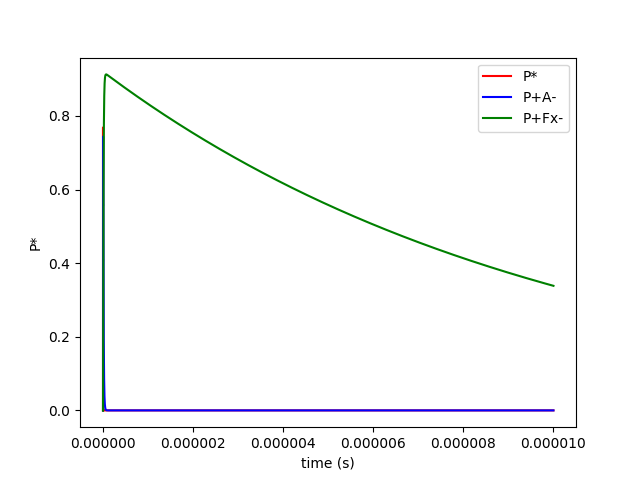

In [12]:
#A 3-stage RC with two decay routes

#y[0] is gnd state
#y[1] is Pstar
#y[2] is P+I-, or Pp_Im
#y[3] is P+Fx-, or Pp_Fxm
 
#six rate constants:
# PAR, excitation ground-->Pp
# k_recombination, Pp--> ground state
# kPstar_Pp_Im, electron transfer from P* --> P+I-
# kPstar_Im_Pp, reverse electron transfer from P+I- --> P*

#kPp_Im_Pp_Fxm, et from Pp_Im-->Pp_Fxm
#kPp_Fxm_Pp_Im, et from Pp_Fxm-->Pp_Im
# kIm_ground, recombination from P+I- --> ground



def f_triad_RC_multiple_decays(y, t, PAR, k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground,
                               kPp_Im_Pp_Fxm, kPp_Fxm_Pp_Im):
    DPstar = PAR*y[0] -1*k_recombination*y[1] - kPstar_Pp_Im*y[1] 
    DPground = k_recombination*y[1] - PAR*y[0]
    DPp_Im = kPstar_Pp_Im*y[1] - kPstar_Im_Pp*y[2] - kPp_Im_Pp_Fxm*y[2]
    Pp_Fxm = kPp_Im_Pp_Fxm*y[2] - kPp_Fxm_Pp_Im*y[3]
    
    return([DPground, DPstar, DPp_Im, Pp_Fxm])

dark_values=[1,0,0,0] #start with all P in ground state

PAR=0
kPstar_Pp_Im=1e9
kPstar_Im_Pp=1e6
kIm_ground=1e6
kPp_Im_Pp_Fxm=1e8
kPp_Fxm_Pp_Im=1e5

constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground,kPp_Im_Pp_Fxm, kPp_Fxm_Pp_Im)
dark_t = np.linspace(0, 1e-8, 101) #the time of the dark adaptation
dark_baseline = odeint(f_triad_RC_multiple_decays, dark_values, dark_t, args=constants)
dark_end_values=[dark_baseline[-1,0],dark_baseline[-1,1],dark_baseline[-1,2],dark_baseline[-1,3]] 

PAR=10000000000.0 
flash_t = np.linspace(0, 1e-9, 10001) #the time of the dark adaptation
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground,kPp_Im_Pp_Fxm, kPp_Fxm_Pp_Im)
flash = odeint(f_triad_RC_multiple_decays, dark_end_values, flash_t, args=constants)
flash_end_values=[flash[-1,0],flash[-1,1],flash[-1,2], dark_baseline[-1,3]] 
flash_t=flash_t + dark_t[-1]

#now we watch the decay
PAR=0.0
decay_t = np.linspace(0, 1e-5, 10001) #the time of the decay curve
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground,kPp_Im_Pp_Fxm, kPp_Fxm_Pp_Im)
decay = odeint(f_triad_RC_multiple_decays, flash_end_values, decay_t, args=constants)
decay_end_values=[decay[-1,0],decay[-1,1], decay[-1,2], dark_baseline[-1,3]] 
decay_t=decay_t+flash_t[-1]


fig=plt.figure()
ax1=fig.add_subplot(111)

ax1.plot(dark_t,dark_baseline[:,1], color='red', label='P*')
ax1.plot(flash_t,flash[:,1], color='red')
ax1.plot(decay_t,decay[:,1], color='red')

ax1.plot(dark_t,dark_baseline[:,2], color='blue', label='P+A-')
ax1.plot(flash_t,flash[:,2], color='blue')
ax1.plot(decay_t,decay[:,2], color='blue')

ax1.plot(dark_t,dark_baseline[:,3], color='green', label='P+Fx-')
ax1.plot(flash_t,flash[:,3], color='green')
ax1.plot(decay_t,decay[:,3], color='green')
ax1.legend()
ax1.set_xlabel('time (s)')
ax1.set_ylabel('P*')
plt.show()

<IPython.core.display.Javascript object>


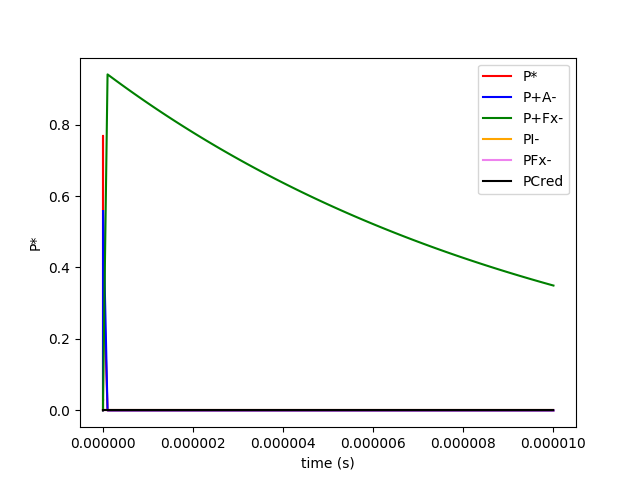

In [13]:
#A 3-stage RC with two decay routes and donor side reactions
# This is a more complex problem because we have to add 4 new states

#y[0] is gnd state
#y[1] is Pstar
#y[2] is P+I-, or Pp_Im
#y[3] is P+Fx-, or Pp_Fxm

#y[4] is PI-, or P_Im
#y[5] is PFx-, or P_Fxm

#y[6] is PCred
#y[7] is PCox


# eight rate constants:
# PAR, excitation ground-->Pp
# k_recombination, Pp--> ground state
# kPstar_Pp_Im, electron transfer from P* --> P+I-
# kPstar_Im_Pp, reverse electron transfer from P+I- --> P*
# kPCred_Pp 
# kPp_PCred 

#the two new ones work on two different sets of states:
#   Pp_Im + PCred --kPCred_Pp--> P_Im + PCox
#   
#   Pp_Fxm + PCred <--kPp_PCred-- P_Fxm + PCox

# AND

#   Pp_Im + PCred --kPCred_Pp--> P_Im + PCox
#   
#   Pp_Fxm + PCred <--kPp_PCred--  P_Fxm + PCox

#Also, the reactions involveing PC are SECOND order, so the equations have a 
#new concentration term


def f_RC_with_PC(y, t, PAR, k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground,
                               kPp_Im_Pp_Fxm, kPp_Fxm_Pp_Im,
                                kPCred_Pp, kPp_PCred):
    
    DPstar = PAR*y[0] -1*k_recombination*y[1] - kPstar_Pp_Im*y[1] 
    DPground = k_recombination*y[1] - PAR*y[0]
    
    DPp_Im = kPstar_Pp_Im*y[1] - kPstar_Im_Pp*y[2] - kPp_Im_Pp_Fxm*y[2] - kPCred_Pp*y[2]*y[6] + kPp_PCred*y[4]*y[7] 
    P_Im = kPCred_Pp*y[2]*y[6] - kPp_PCred*y[4]*y[7]
    
    Pp_Fxm = kPp_Im_Pp_Fxm*y[2] - kPp_Fxm_Pp_Im*y[3] - kPCred_Pp*y[3]*y[6] + kPp_PCred*y[5]*y[7]
    
    P_Fxm = kPCred_Pp*y[3]*y[6] - kPp_PCred*y[5]*y[7]
    
    dPCred = kPp_PCred*y[4]*y[7] + kPp_PCred*y[5]*y[7] - kPCred_Pp*y[2]*y[6] - kPCred_Pp*y[3]*y[6]
    
    dPCox = -1 * dPCred
    
    return([DPground, DPstar, DPp_Im, Pp_Fxm, P_Im, P_Fxm, dPCred, dPCox])

dark_values=[1,0,0,0,0,0,0,1] #start with all P in ground state

PAR=0
kPstar_Pp_Im=1e9
kPstar_Im_Pp=1e6
kIm_ground=1e6
kPp_Im_Pp_Fxm=1e8
kPp_Fxm_Pp_Im=1e5
kPCred_Pp = 3e5
kPp_PCred = 1e4

constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground,kPp_Im_Pp_Fxm, kPp_Fxm_Pp_Im, kPCred_Pp, kPp_PCred)
dark_t = np.linspace(0, 1e-8, 101) #the time of the dark adaptation
dark_baseline = odeint(f_RC_with_PC, dark_values, dark_t, args=constants)

dark_end_values=dark_baseline[-1][:] #[dark_baseline[-1,0],dark_baseline[-1,1],dark_baseline[-1,2],dark_baseline[-1,3]] 

len(dark_baseline[0])


PAR=10000000000.0 
flash_t = np.linspace(0, 1e-9, 101) #the time of the dark adaptation
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground,kPp_Im_Pp_Fxm, kPp_Fxm_Pp_Im, kPCred_Pp, kPp_PCred)
flash = odeint(f_RC_with_PC, dark_end_values, flash_t, args=constants)
flash_end_values=flash[-1][:]   #[flash[-1,0],flash[-1,1],flash[-1,2], dark_baseline[-1,3]] 
flash_t=flash_t + dark_t[-1]

#now we watch the decay
PAR=0.0
decay_t = np.linspace(0, 1e-5, 101) #the time of the decay curve
constants=(PAR,k_recombination, kPstar_Pp_Im, kPstar_Im_Pp, kIm_ground,kPp_Im_Pp_Fxm, kPp_Fxm_Pp_Im, kPCred_Pp, kPp_PCred)
decay = odeint(f_RC_with_PC, flash_end_values, decay_t, args=constants)
decay_end_values=  decay[-1][:]   #[decay[-1,0],decay[-1,1], decay[-1,2], dark_baseline[-1,3]] 
decay_t=decay_t+flash_t[-1]


fig=plt.figure()
ax1=fig.add_subplot(111)

ax1.plot(dark_t,dark_baseline[:,1], color='red', label='P*')
ax1.plot(flash_t,flash[:,1], color='red')
ax1.plot(decay_t,decay[:,1], color='red')

ax1.plot(dark_t,dark_baseline[:,2], color='blue', label='P+A-')
ax1.plot(flash_t,flash[:,2], color='blue')
ax1.plot(decay_t,decay[:,2], color='blue')

ax1.plot(dark_t,dark_baseline[:,3], color='green', label='P+Fx-')
ax1.plot(flash_t,flash[:,3], color='green')
ax1.plot(decay_t,decay[:,3], color='green')

ax1.plot(dark_t,dark_baseline[:,4], color='orange', label='PI-')
ax1.plot(flash_t,flash[:,4], color='orange')
ax1.plot(decay_t,decay[:,4], color='orange')

ax1.plot(dark_t,dark_baseline[:,5], color='violet', label='PFx-')
ax1.plot(flash_t,flash[:,5], color='violet')
ax1.plot(decay_t,decay[:,5], color='violet')

ax1.plot(dark_t,dark_baseline[:,6], color='black', label='PCred')
ax1.plot(flash_t,flash[:,6], color='black')
ax1.plot(decay_t,decay[:,6], color='black')


ax1.legend()


ax1.set_xlabel('time (s)')
ax1.set_ylabel('P*')
plt.show()